In [1]:
import sys
sys.path.append("../")
import numpy as np
import os
import glob
import cv2
import csv
from utils import AnteriorPosterior, tripleplot
import pandas as pd
from tifffile import imread, imwrite
import matplotlib.pyplot as plt
try:
    from pathlib import Path
    Path().expanduser()
except (ImportError, AttributeError):
        from pathlib2 import Path

try:
        import tempfile
        tempfile.TemporaryDirectory
except (ImportError, AttributeError):
       from backports import tempfile

In [2]:
Kymo = '/home/kapoorlab/Downloads/Darine/Dpachys_10/DistanceMethodCurvature_Dpachys_10-adjustedTrackID1.tif'
Embryo = '/home/kapoorlab/Downloads/Darine/Dpachys_10/Dpachys_10-adjusted.tif'
Csv = '/home/kapoorlab/Downloads/Darine/Dpachys_10/Co-ordinatesETrack_Dpachys_10-adjustedCellID01.txt'
savedir = '/home/kapoorlab/Downloads/Darine/Dpachys_10/Results/'
Time_unit = 10
Xcalibration = 0.034
Kymoimage = imread(Kymo)
Embryoimage = imread(Embryo)
# Skip the display points on the clock
displayskip = 2
blocksize = 50
Path(savedir).mkdir(exist_ok = True)

AnteriorStart = 0
AnteriorEnd = Kymoimage.shape[0]//2
PosteriorStart = AnteriorEnd
PosteriorEnd = Kymoimage.shape[0]

In [3]:

x, y, t, distance, perimeter, N, M = np.loadtxt(Csv, skiprows = 3, unpack=True)
Blockiter = int(len(x)/max(t))
print('Total Perimeter points on Kymo:', Blockiter)
Dictionary = []
for i in range(0, Blockiter):
    Dictionary.append([i, x[i], y[i]])


Total Perimeter points on Kymo: 2352


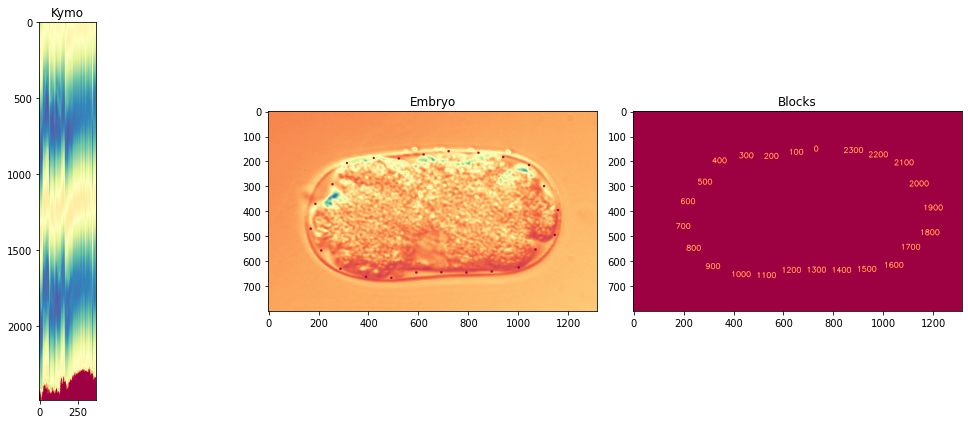

In [4]:
# font 
font = cv2.FONT_HERSHEY_SIMPLEX 
# org 
org = (50, 50) 
# fontScale 
fontScale = 1
 
color = (255, 255, 0) 
thickness = 1
Clock = np.zeros([Embryoimage.shape[1], Embryoimage.shape[2]])
for i in range(0, Blockiter, 2 *blocksize):
    cv2.circle(Embryoimage[0,:], (int(x[i]), int(y[i])), 5,(255,0,0), thickness = -1 )
    cv2.putText(Clock, str(i), (int(x[i]), int(y[i])), font,  
                   fontScale, color, thickness, cv2.LINE_AA)
tripleplot(Kymoimage,Embryoimage[0,:], Clock, 'Kymo', 'Embryo', 'Blocks')

Mean Velocity over time Anterior 2.4071553833007817 um/min
Mean Velocity over time Posterior 14.38596611328125 um/min


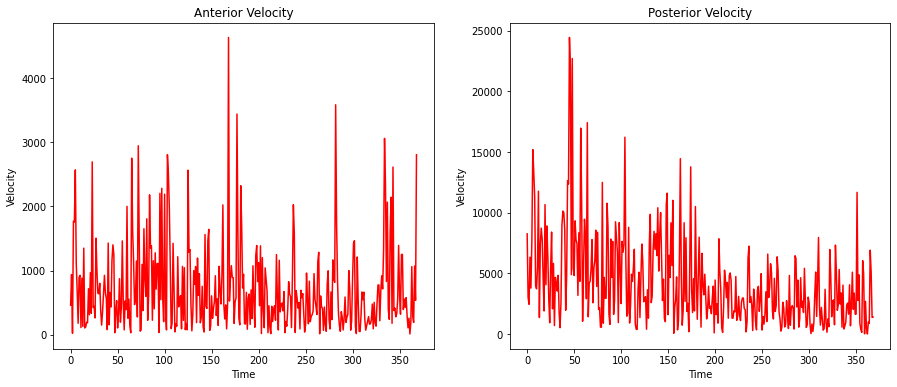

In [9]:
Name = os.path.basename(os.path.splitext(Kymo)[0])
Time, AnteriorVelocity, PosteriorVelocity = AnteriorPosterior(Kymoimage, AnteriorStart, AnteriorEnd, PosteriorStart, PosteriorEnd)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
ax = axes.ravel()
ax[0].plot( Time, AnteriorVelocity, 'r')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Velocity')
ax[0].set_title('Anterior Velocity')

ax[1].plot( Time, PosteriorVelocity, 'r')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Velocity')
ax[1].set_title('Posterior Velocity')

print('Mean Velocity over time Anterior', np.mean(AnteriorVelocity) * Xcalibration/ Time_unit , "um/min")
print('Mean Velocity over time Posterior', np.mean(PosteriorVelocity)* Xcalibration/ Time_unit , "um/min")